In [829]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import scipy

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plot
import pylab

### 1. Загружаем исторические данные по нужным тикерам

Для этого используем предустановленную библиотеку yfinance

In [701]:
df1 = yf.download('AAPL', period = '10y') 
df2 = yf.download('META', period = '10y') 
df3 = yf.download('GOOGL', period = '10y') 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Делаем датафреймы для каждого тикера с 1 признаком (цена закрытия до коррекции)

In [702]:
dfA = pd.DataFrame(df1, columns = ['Close'])
dfM = pd.DataFrame(df2, columns = ['Close'])
dfG = pd.DataFrame(df3, columns = ['Close'])

In [703]:
print(dfA.head())
print(dfA.shape)

                Close
Date                 
2012-12-03  20.935356
2012-12-04  20.566071
2012-12-05  19.242500
2012-12-06  19.544287
2012-12-07  19.044643
(2519, 1)


In [704]:
print(dfM.head())
print(dfM.shape)

                Close
Date                 
2012-12-03  27.040001
2012-12-04  27.459999
2012-12-05  27.709999
2012-12-06  26.969999
2012-12-07  27.490000
(2519, 1)


In [705]:
print(dfG.head())
print(dfG.shape)

                Close
Date                 
2012-12-03  17.398649
2012-12-04  17.293043
2012-12-05  17.212713
2012-12-06  17.295546
2012-12-07  17.122372
(2519, 1)


#### Соберем отдельные датафреймы в один.

In [706]:
df_concat = pd.concat([dfA, dfM, dfG], axis = 1)
df_concat.columns = ['Close AAPL', 'Close META', 'Close GOOGL']
print(df_concat.head())
print(df_concat.shape)

            Close AAPL  Close META  Close GOOGL
Date                                           
2012-12-03   20.935356   27.040001    17.398649
2012-12-04   20.566071   27.459999    17.293043
2012-12-05   19.242500   27.709999    17.212713
2012-12-06   19.544287   26.969999    17.295546
2012-12-07   19.044643   27.490000    17.122372
(2519, 3)


Посмотрим на числовые значения тикеров

In [707]:
df_concat.describe().loc[['mean', 'std']]

,Close AAPL,Close META,Close GOOGL
mean,61.510816,154.850079,58.944707
std,48.412872,84.594640,34.710123


#### Посморим на графики

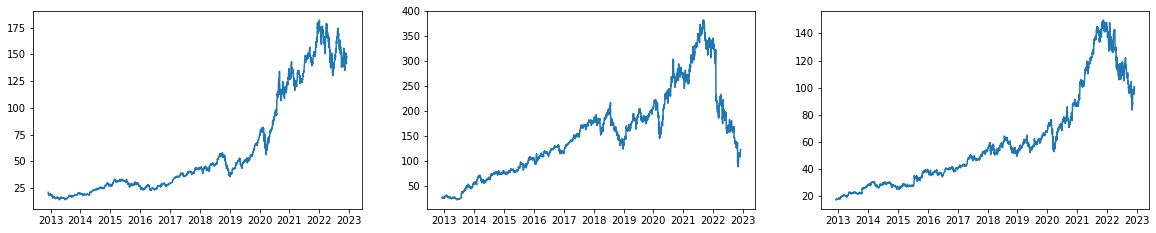

In [708]:
tickers = ['Close AAPL', 'Close META', 'Close GOOGL']
plt.subplots(figsize = (20,8))
for i, col in enumerate(tickers):
    plt.subplot(2,3,i+1)
    plt.plot(df_concat[col])
plt.show()

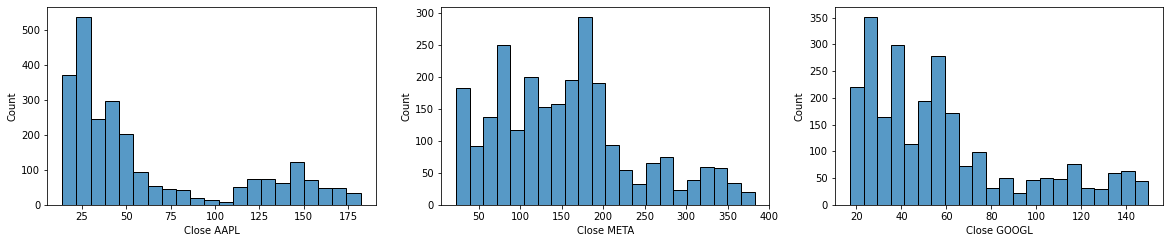

In [709]:
plt.subplots(figsize = (20,8))
for i, col in enumerate(tickers):
    plt.subplot(2,3,i+1)
    sb.histplot(df_concat[col])
plt.show()

Исходя из графиков видим ненормальное распределение цены. 

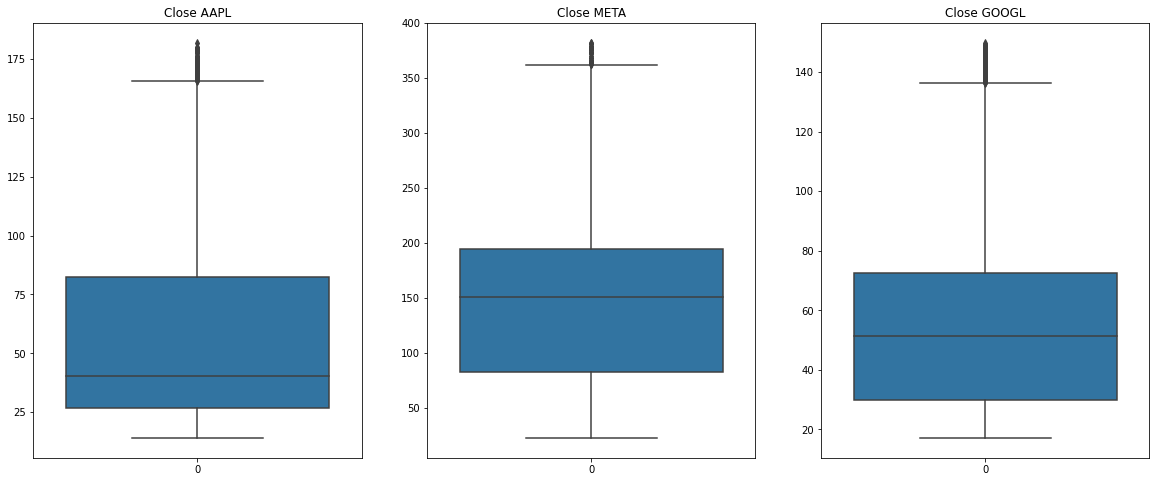

In [710]:
plt.subplots(figsize = (20,8))
for i, col in enumerate(tickers):
    plt.subplot(1,3,i+1)
    plt.title(tickers[i])
    sb.boxplot(data=df_concat[col])
plt.show()

Видим, что у AAPL и GOOGL больше аномально высоких цен на акцию.

### Задание 2

#### Считаем daily returns

In [711]:
df_concat['DR AAPL'] = df_concat['Close AAPL'].pct_change(1).fillna(method='bfill')
df_concat['DR META'] = df_concat['Close META'].pct_change(1).fillna(method='bfill')
df_concat['DR GOOGL'] = df_concat['Close GOOGL'].pct_change(1).fillna(method='bfill')

Визуализируем полученные данные.

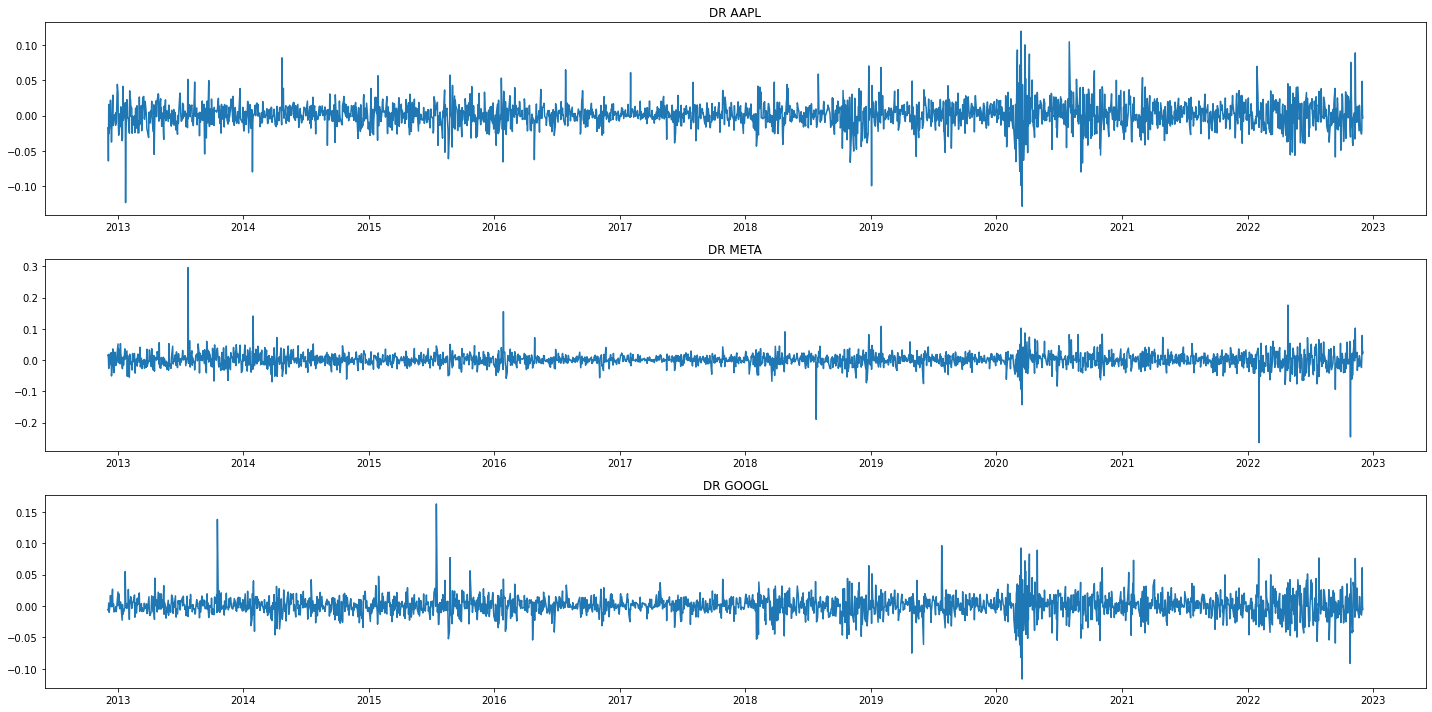

In [712]:
returns = ['DR AAPL', 'DR META', 'DR GOOGL']
fig, ax = plt.subplots(figsize = (20,10))
for i, col in enumerate(returns):
    plt.subplot(3,1,i+1)
    plt.title(returns[i])
    plt.plot(df_concat[col])
fig.tight_layout()
plt.show()

Сильная волатильность всех тикеров связана с началом COVID-19. Также хорошо видны сильные падения цены у META в начале и в конце 2022.

Посмотрим на статистику полученных данных

In [713]:
df_concat.describe()

,Close AAPL,Close META,Close GOOGL,DR AAPL,DR META,DR GOOGL
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000
mean,61.510816,154.850079,58.944707,0.000938,0.000899,0.000837
std,48.412872,84.594640,34.710123,0.018366,0.023976,0.016992
min,13.947500,22.900000,17.122372,-0.128647,-0.263901,-0.116341
25%,26.705000,82.915001,29.954980,-0.007566,-0.009652,-0.006773
50%,40.375000,151.059998,51.505001,0.000749,0.001050,0.000825
75%,82.337502,194.395004,72.542000,0.010352,0.012534,0.008994
max,182.009995,382.179993,149.838501,0.119808,0.296115,0.162584


#### Проверяем нормальность распределения

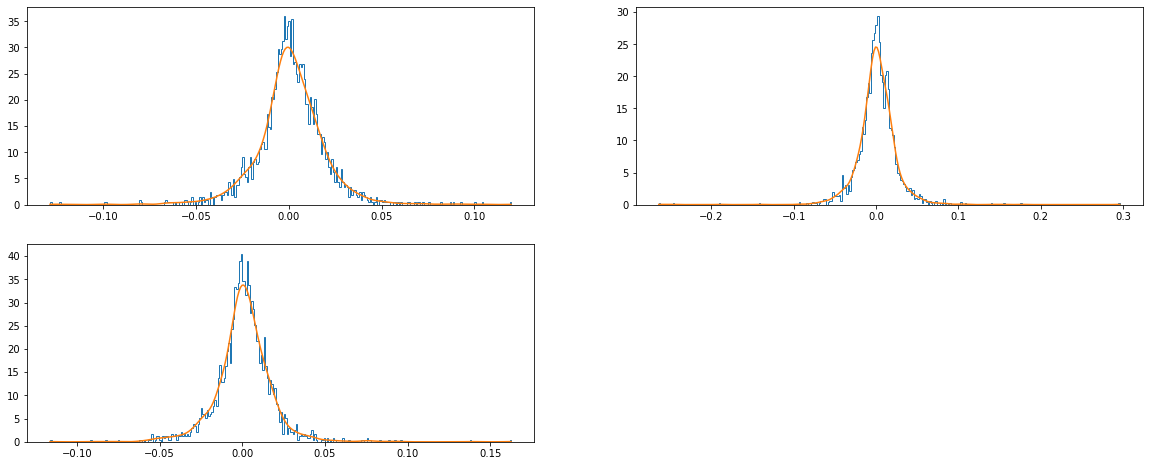

In [714]:
returns = ['DR AAPL', 'DR META', 'DR GOOGL']
plt.subplots(figsize = (20,8))
for i, col in enumerate(returns):
    plt.subplot(2,2,i+1)
    data = df_concat[col]
    n, x, _ = plt.hist(data, bins=300, histtype=u'step', density=True)
    gauss = stats.gaussian_kde(data)
    plt.plot(x, gauss(x))
plt.show()

Мы видим, что распределение returns схоже с распределоением Гаусса (оранжевая линия).

Проверим нормальность распределения на графике Quantile-Quantile

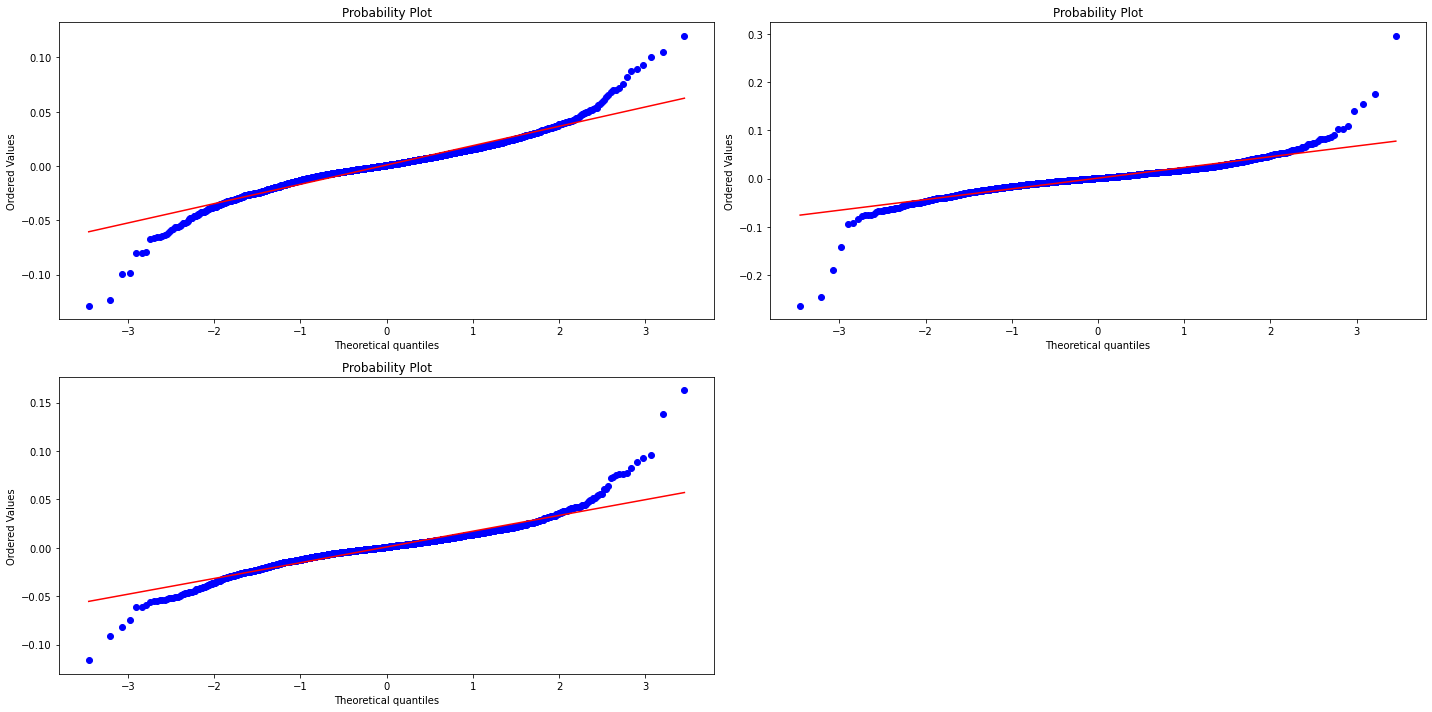

In [715]:
returns = ['DR AAPL', 'DR META', 'DR GOOGL']
fig, ax = plt.subplots(figsize = (20,10))
for i, col in enumerate(returns):
    plt.subplot(2,2,i+1)
    stats.probplot(df_concat[col], dist="norm", plot=pylab)
fig.tight_layout()
pylab.show()

Если точки на графике ложатся примерно на прямую диагональную линию, мы обычно предполагаем, что набор данных имеет нормальное распределение.\
Вывод: \
не все данные лежат на красной линии, значит есть признак ненормального распределения.

#### Проводим тест Шапиро-Уилк

In [716]:
def shapiro(data):
    stat, p = scipy.stats.shapiro(data)
    print('Statistics=%.3f, p-value=%.3f' % (stat, p)) 
    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')
    return stat, p

In [717]:
print('DR AAPL \n')
shapiro(df_concat['DR AAPL'])

DR AAPL 

Statistics=0.939, p-value=0.000
Отклонить гипотезу о нормальности


(0.9386555552482605, 4.471834417307759e-31)

In [718]:
print('DR META \n')
shapiro(df_concat['DR META'])

DR META 

Statistics=0.860, p-value=0.000
Отклонить гипотезу о нормальности


(0.8601030707359314, 1.0369608636003646e-42)

In [719]:
print('DR GOOGL \n')
shapiro(df_concat['DR GOOGL'])

DR GOOGL 

Statistics=0.919, p-value=0.000
Отклонить гипотезу о нормальности


(0.9186623692512512, 7.698112761331017e-35)

Вывод: \
Так как p-value существенно < 0.05, мы отклоняем гипотезу и признаем что распределение не нормально. \
Несмотря на то что график данных имеет форму правильного колокола и схож с формой графика нормального распределения, статистика говорит о ненормальном распределении.

#### Посмотрим на критерий Пирсона

In [720]:
def pirson(data):
    stat, p = scipy.stats.normaltest(data) # Критерий согласия Пирсона
    print('Statistics=%.3f, p-value=%.3f' % (stat, p)) 
    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')

In [721]:
print('DR AAPL \n')
pirson(df_concat['DR AAPL'])

DR AAPL 

Statistics=320.799, p-value=0.000
Отклонить гипотезу о нормальности


In [722]:
print('DR META \n')
pirson(df_concat['DR META'])

DR META 

Statistics=683.563, p-value=0.000
Отклонить гипотезу о нормальности


In [723]:
print('DR GOOGL \n')
pirson(df_concat['DR GOOGL'])

DR GOOGL 

Statistics=514.466, p-value=0.000
Отклонить гипотезу о нормальности


#### Посмотрим другие статистики

In [724]:
def statistics(data):
    print ('Коэффициент ассиметрии: ', round(scipy.stats.skew(data), 4))
    print ('Коэффициент вариации: ', round(scipy.stats.kurtosis(data), 4))
    print ('% данных между -2 и +2 сигмами', round(1 
                                                    - ((data < -2 * data.std()).sum() 
                                                    + (data > 2 * data.std()).sum())
                                                    /len(data), 4))
    print ('% данных между -3 и +3 сигмами', round(1 
                                                    - ((data < -3 * data.std()).sum() 
                                                    + (data > 3 * data.std()).sum())
                                                    /len(data), 4))

In [725]:
print('DR AAPL \n')
statistics(df_concat['DR AAPL'])

DR AAPL 

Коэффициент ассиметрии:  -0.14
Коэффициент вариации:  5.6898
% данных между -2 и +2 сигмами 0.9512
% данных между -3 и +3 сигмами 0.9849


In [726]:
print('DR META \n')
statistics(df_concat['DR META'])

DR META 

Коэффициент ассиметрии:  -0.1271
Коэффициент вариации:  24.0486
% данных между -2 и +2 сигмами 0.9559
% данных между -3 и +3 сигмами 0.9881


In [727]:
print('DR GOOGL \n')
statistics(df_concat['DR GOOGL'])

DR GOOGL 

Коэффициент ассиметрии:  0.5038
Коэффициент вариации:  8.8399
% данных между -2 и +2 сигмами 0.9488
% данных между -3 и +3 сигмами 0.9845


Вывод: \
Если наблюдения подчиняются нормальному распределению, то асимметрия равна нулю. \
Коэффициент вариации равен нулю, если наблюдения подчиняются нормальному распределению. \
В нашем случве мы скорее говорим о ненормальном распределении данных.

#### Стационарность временного ряда

In [728]:
def stationary(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [729]:
print('DR AAPL \n')
stationary(df_concat['DR AAPL'])

DR AAPL 

ADF Statistic: -16.432582
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [730]:
print('DR META \n')
stationary(df_concat['DR META'])

DR META 

ADF Statistic: -17.360166
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [731]:
print('DR GOOGL \n')
stationary(df_concat['DR GOOGL'])

DR GOOGL 

ADF Statistic: -11.277584
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Вывод: \
так как p-value < 0.05 и значение статистики отрицательно и сильно меньше чем критическое значение 1%, мы отвергаем гипотезу и признаем значения временных рядов стационарными).

### Автокорреляция

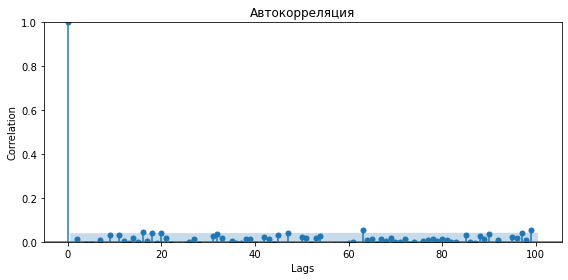

In [732]:
plt.rc("figure", figsize=(8,4))
plot_acf(df_concat['DR META'], lags=100)
plt.ylim(0,1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Автокорреляция')
plt.tight_layout()
plt.show()

Вывод: /
Не обнаружена автокорреляция между данными временных рядов. \
Голубая зона на графике показывает статистическую значимость временных точек - лагов (для экспиремента мы выбрали 100 точек). Мы видим отсутствие значимости точек.

### Корреляции

In [733]:
print(df_concat['DR AAPL'].corr(df_concat['DR META']))

0.4777165747194991


In [734]:
print(df_concat['DR AAPL'].corr(df_concat['DR META'], method='spearman'))

0.478726237930902


In [735]:
print(df_concat['DR AAPL'].corr(df_concat['DR META'], method='kendall'))

0.3400838146272669


Метод Кендалла дает наименьший коэффициент корреляции так как в его основе лежит система ранжирования более чутко реагирующая на кратковременные взлеты и падения, тем самым занижая корреляцию.

#### Посмотрим на матрицу корреляций всех инструментов

In [736]:
corr_df = df_concat.corr()
corr_df

,Close AAPL,Close META,Close GOOGL,DR AAPL,DR META,DR GOOGL
Close AAPL,1.000000,0.787700,0.964476,0.018465,-0.040047,-0.004330
Close META,0.787700,1.000000,0.866079,0.040201,-0.006007,0.022550
Close GOOGL,0.964476,0.866079,1.000000,0.019198,-0.036590,0.004583
DR AAPL,0.018465,0.040201,0.019198,1.000000,0.477717,0.569223
DR META,-0.040047,-0.006007,-0.036590,0.477717,1.000000,0.593485
DR GOOGL,-0.004330,0.022550,0.004583,0.569223,0.593485,1.000000


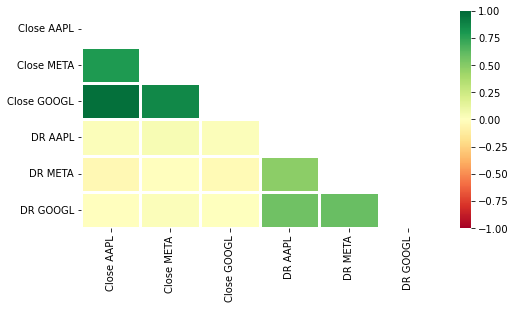

In [737]:
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

#### Тест Гранжера

In [738]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag = 12):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [739]:
grangers_causation_matrix(df_concat, variables = df_concat.columns)  

,Close AAPL_x,Close META_x,Close GOOGL_x,DR AAPL_x,DR META_x,DR GOOGL_x
Close AAPL_y,1.0000,0.0000,0.0000,0.0018,0.0000,0.0000
Close META_y,0.0002,1.0000,0.0000,0.0001,0.0544,0.0001
Close GOOGL_y,0.0003,0.0003,1.0000,0.0003,0.0270,0.0018
DR AAPL_y,0.1369,0.0117,0.0073,1.0000,0.0039,0.0000
DR META_y,0.0000,0.0128,0.0000,0.0000,1.0000,0.0002
DR GOOGL_y,0.0280,0.2792,0.1631,0.0043,0.6088,1.0000


Нулевая гипотеза: переменная х не влияет на переменную у. \
В случае, если p-value меньше 0.05, мы не отвергаем нулевую гипотезу.\
Если гипотеза «x не влияет на y» не отвергается, то это означает, что x не является причиной y

### Задание 3

Генерируем случайную выборку со нормальным распределением

In [740]:
len(df_concat)

2519

In [741]:
s = np.random.normal(loc = 0.0, scale = 1.0, size = len(df_concat))
len(s)

2519

In [742]:
s1 = np.random.normal(loc = 0.0, scale = 1.0, size = len(df_concat))
len(s1)

2519

In [743]:
df_pnl = df_concat.copy()

In [744]:
df_pnl['f'] = s
df_pnl['f1'] = s1
df_pnl.head()

,Close AAPL,Close META,Close GOOGL,DR AAPL,DR META,DR GOOGL,f,f1
Date,,,,,,,,
2012-12-03,20.935356,27.040001,17.398649,-0.017639,0.015532,-0.006070,0.359238,-1.402406
2012-12-04,20.566071,27.459999,17.293043,-0.017639,0.015532,-0.006070,-0.670225,2.007053
2012-12-05,19.242500,27.709999,17.212713,-0.064357,0.009104,-0.004645,-0.381176,-0.469670
2012-12-06,19.544287,26.969999,17.295546,0.015683,-0.026705,0.004812,1.432939,-0.173834
2012-12-07,19.044643,27.490000,17.122372,-0.025565,0.019281,-0.010013,-1.147121,-2.057088


Считаем pnl и строим графики

In [745]:
df1 = df_pnl[['DR AAPL', 'DR META', 'DR GOOGL']].multiply(df_pnl['f'], axis='index')
df1.columns = ['PNL AAPL', 'PNL META', 'PNL GOOGL']

In [746]:
df2 = df_pnl[['DR AAPL', 'DR META', 'DR GOOGL']].multiply(df_pnl['f1'], axis='index')
df2.columns = ['PNL1 AAPL', 'PNL1 META', 'PNL1 GOOGL']

In [747]:
df_pnl = pd.concat([df_pnl, df1, df2], axis = 1)

In [748]:
df_pnl.head()

,Close AAPL,Close META,Close GOOGL,DR AAPL,DR META,DR GOOGL,f,f1,PNL AAPL,PNL META,PNL GOOGL,PNL1 AAPL,PNL1 META,PNL1 GOOGL
Date,,,,,,,,,,,,,,
2012-12-03,20.935356,27.040001,17.398649,-0.017639,0.015532,-0.006070,0.359238,-1.402406,-0.006337,0.005580,-0.002180,0.024737,-0.021783,0.008512
2012-12-04,20.566071,27.459999,17.293043,-0.017639,0.015532,-0.006070,-0.670225,2.007053,0.011822,-0.010410,0.004068,-0.035403,0.031175,-0.012182
2012-12-05,19.242500,27.709999,17.212713,-0.064357,0.009104,-0.004645,-0.381176,-0.469670,0.024531,-0.003470,0.001771,0.030227,-0.004276,0.002182
2012-12-06,19.544287,26.969999,17.295546,0.015683,-0.026705,0.004812,1.432939,-0.173834,0.022473,-0.038267,0.006896,-0.002726,0.004642,-0.000837
2012-12-07,19.044643,27.490000,17.122372,-0.025565,0.019281,-0.010013,-1.147121,-2.057088,0.029326,-0.022117,0.011486,0.052589,-0.039662,0.020597


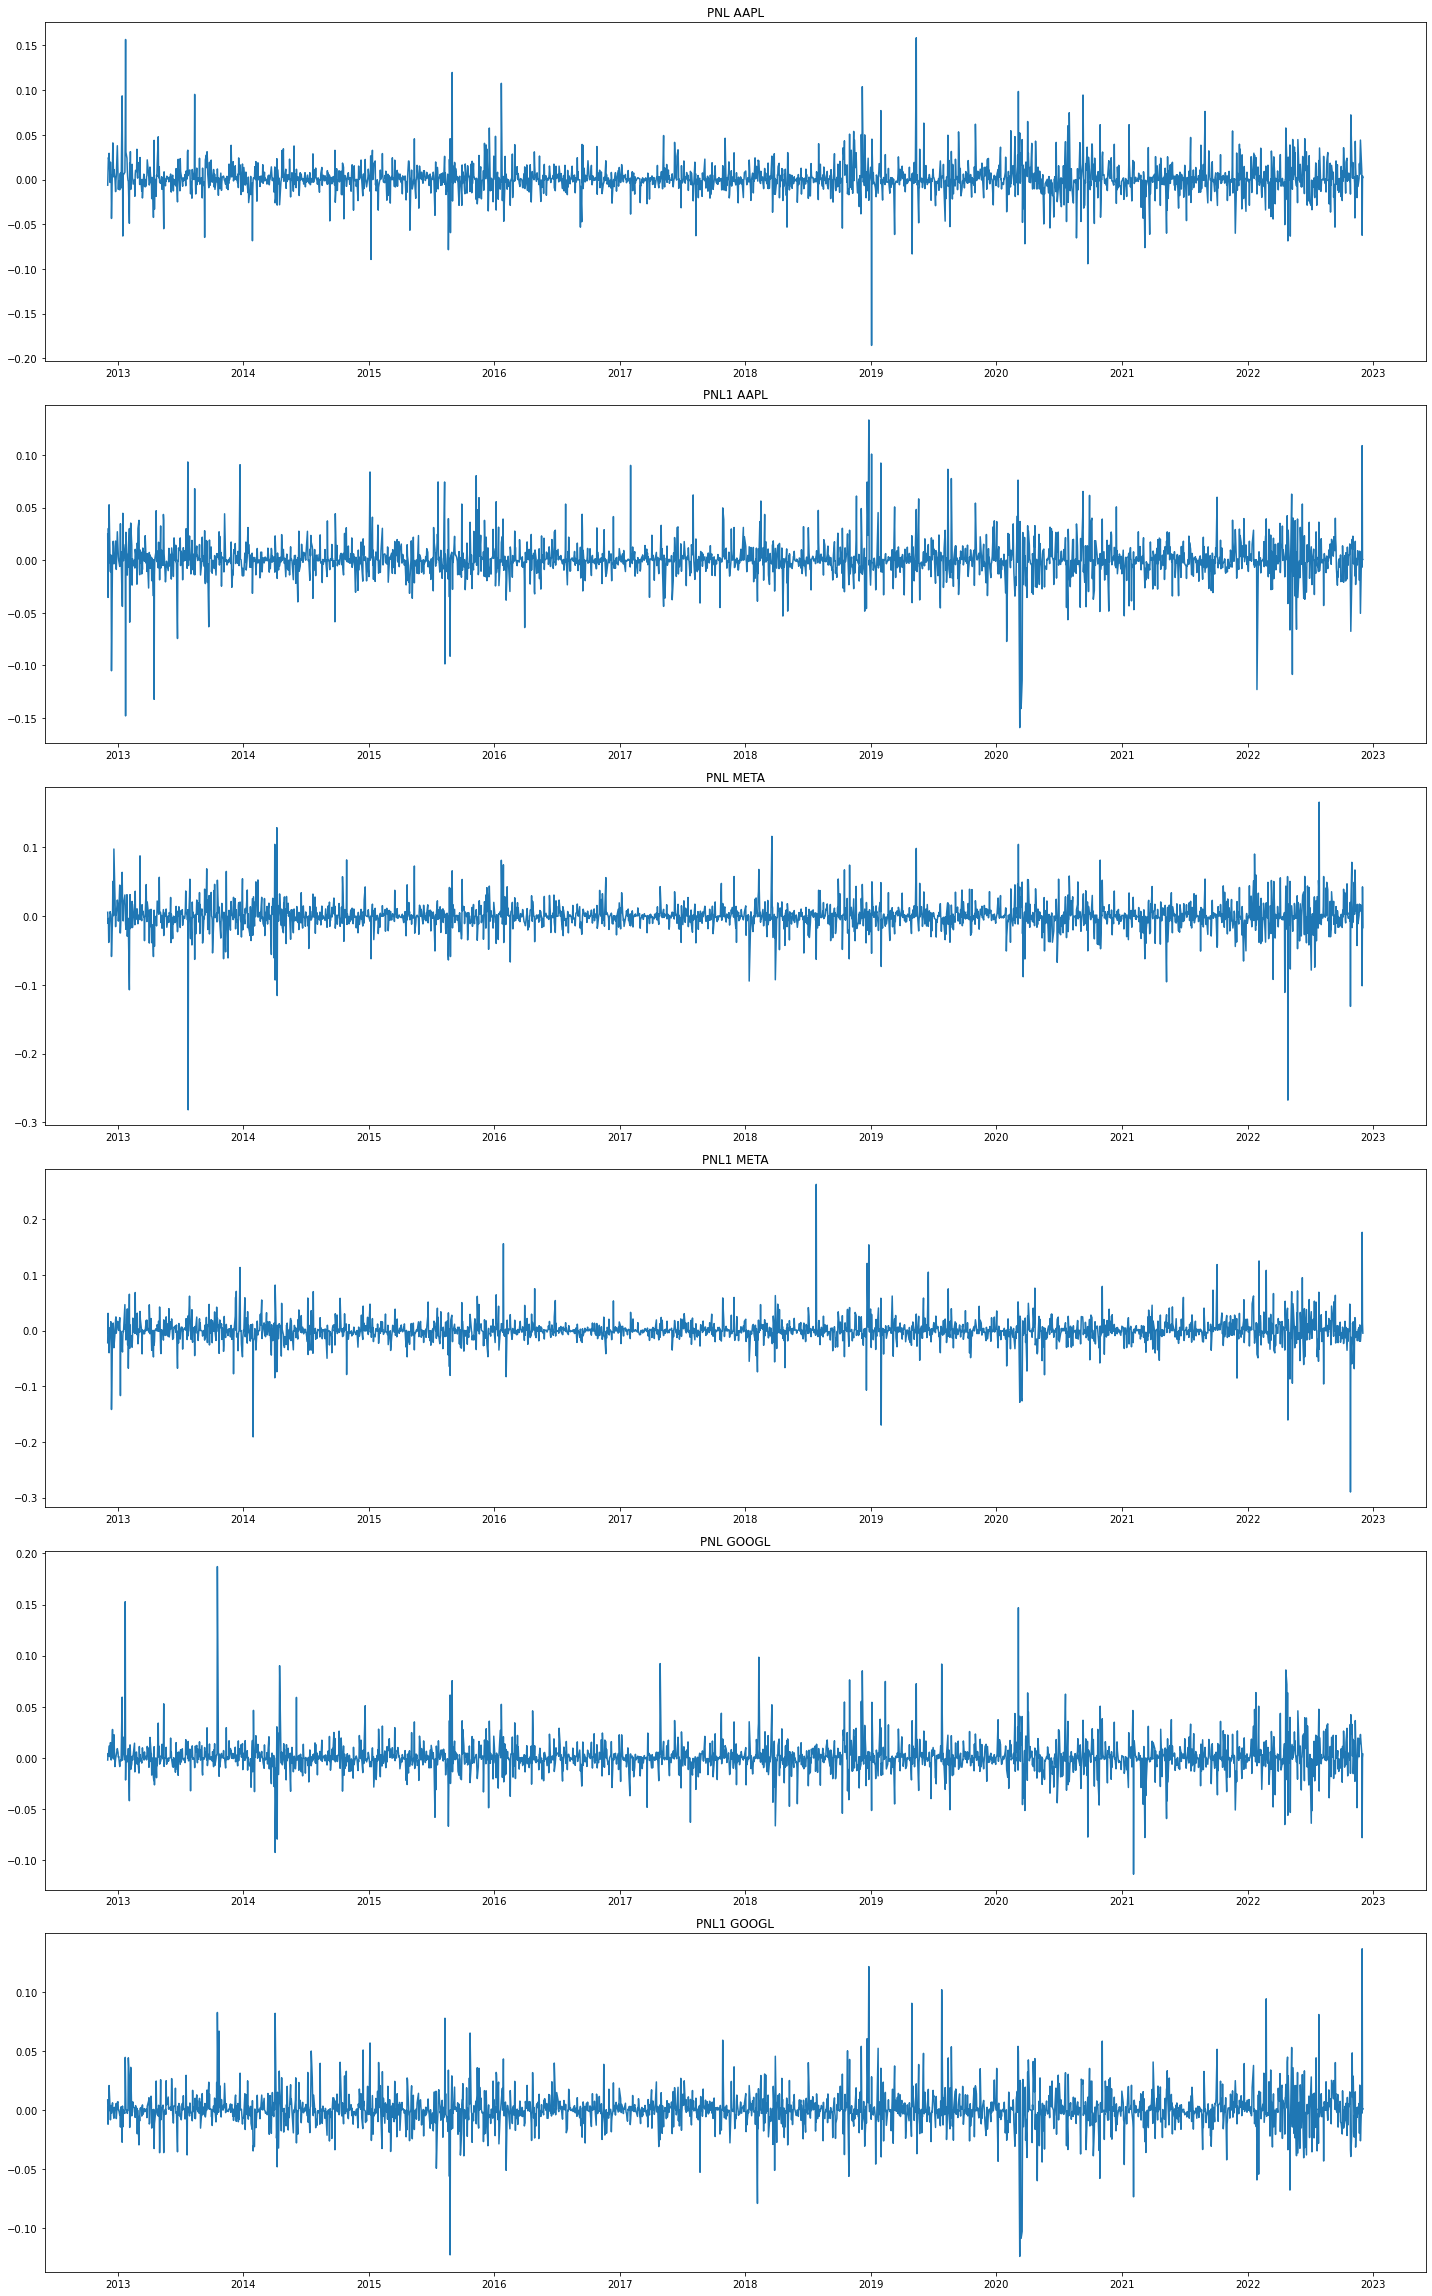

In [749]:
pnl = ['PNL AAPL', 'PNL1 AAPL', 'PNL META', 'PNL1 META', 'PNL GOOGL', 'PNL1 GOOGL']
fig, ax = plt.subplots(figsize = (20,32))
for i, col in enumerate(pnl):
    plt.subplot(6,1,i+1)
    plt.title(pnl[i])
    plt.plot(df_pnl[col])
fig.tight_layout()
plt.show()

Считаем кумулятивную сумму pnl по двум сгенерированным базам

In [750]:
df_pnl['cums PNL AAPL'] = np.cumsum(df_pnl['PNL AAPL'])
df_pnl['cums PNL META'] = np.cumsum(df_pnl['PNL META'])
df_pnl['cums PNL GOOGL'] = np.cumsum(df_pnl['PNL GOOGL'])

df_pnl['cums PNL1 AAPL'] = np.cumsum(df_pnl['PNL1 AAPL'])
df_pnl['cums PNL1 META'] = np.cumsum(df_pnl['PNL1 META'])
df_pnl['cums PNL1 GOOGL'] = np.cumsum(df_pnl['PNL1 GOOGL'])

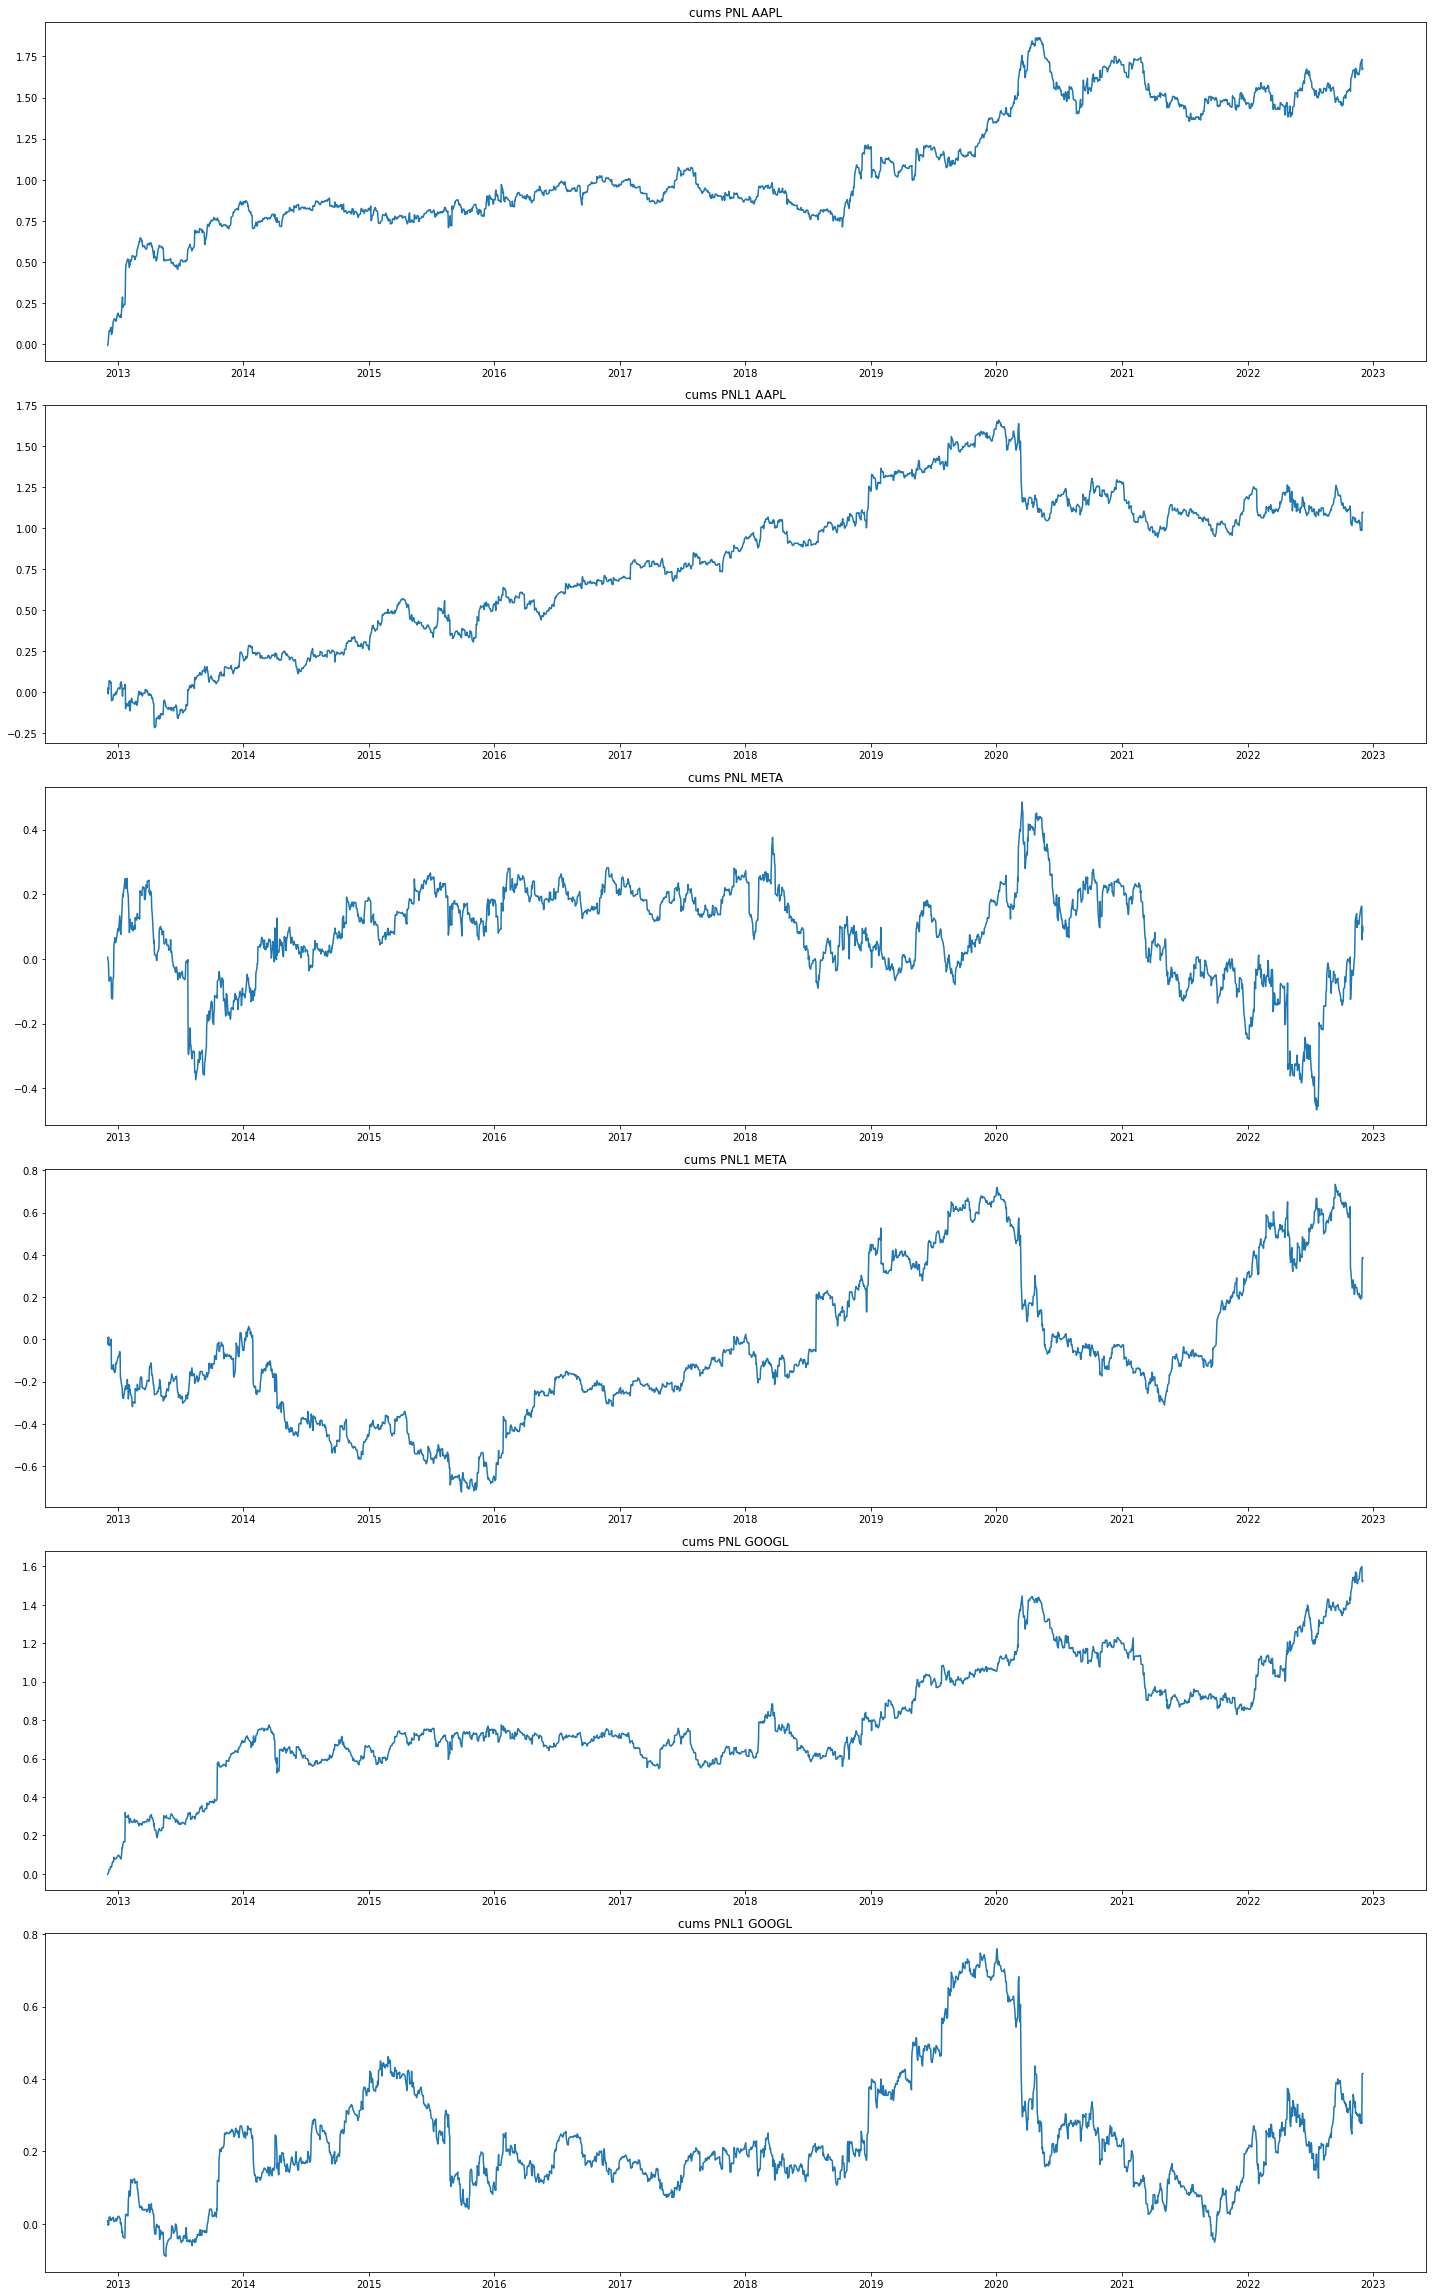

In [751]:
cumsum_pnl = ['cums PNL AAPL', 'cums PNL1 AAPL', 'cums PNL META', 'cums PNL1 META', 'cums PNL GOOGL', 'cums PNL1 GOOGL']
fig, ax = plt.subplots(figsize = (20,32))
for i, col in enumerate(cumsum_pnl):
    plt.subplot(6,1,i+1)
    plt.title(cumsum_pnl[i])
    plt.plot(df_pnl[col])
fig.tight_layout()
plt.show()

### Задание 4

Создаем отдельные датафреймы

In [752]:
df_pnl_sharp = df1.copy()

In [753]:
df_pnl_sharp_1 = df2.copy()

#### Считаем sharpe ratio для PLN, полученных из случайной выборки f

<AxesSubplot:>

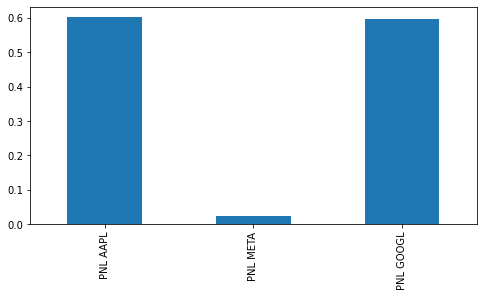

In [838]:
def sharpe_ratio(data, N, rf):
    mean = data.mean() * N - rf
    sigma = data.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf = 0 #0% risk free rate
sharpes = df_pnl_sharp.apply(sharpe_ratio, args=(N, rf), axis=0)

sharpes.plot.bar()

#### Считаем sharpe ratio для PLN1, полученных из случайной выборки f1

<AxesSubplot:>

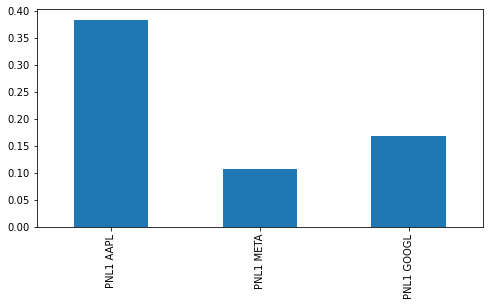

In [839]:
def sharpe_ratio(data, N, rf):
    mean = data.mean() * N - rf
    sigma = data.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0 #0% risk free rate
sharpes1 = df_pnl_sharp_1.apply(sharpe_ratio, args=(N, rf), axis=0)

sharpes1.plot.bar()

#### Считаем hit rate для PLN, полученных из случайной выборки f

In [840]:
df_hit = df_concat.copy()

In [841]:
df_hit ['f'] = s
df_hit ['f1'] = s1

In [842]:
df_hit['Gain AAPL'] = np.sign(df_hit['DR AAPL']) == np.sign(df_hit['f'])
df_hit['Gain META'] = np.sign(df_hit['DR META']) == np.sign(df_hit['f'])
df_hit['Gain GOOGL'] = np.sign(df_hit['DR GOOGL']) == np.sign(df_hit['f'])

In [843]:
hit_ratio_AAPL = df_hit['Gain AAPL'].sum()/len(df_hit)
print(hit_ratio_AAPL)

0.5148868598650258


In [844]:
hit_ratio_META = df_hit['Gain META'].sum()/len(df_hit)
print(hit_ratio_META)

0.49503771337832475


In [845]:
hit_ratio_GOOGL = df_hit['Gain GOOGL'].sum()/len(df_hit)
print(hit_ratio_GOOGL)

0.5021834061135371


In [846]:
hits = [hit_ratio_AAPL, hit_ratio_META, hit_ratio_GOOGL]

#### Считаем hit rate для PLN, полученных из случайной выборки f1

In [847]:
df_hit['Gain AAPL 1'] = np.sign(df_hit['DR AAPL']) == np.sign(df_hit['f1'])
df_hit['Gain META 1'] = np.sign(df_hit['DR META']) == np.sign(df_hit['f1'])
df_hit['Gain GOOGL 1'] = np.sign(df_hit['DR GOOGL']) == np.sign(df_hit['f1'])

In [848]:
hit_ratio_AAPL_1 = df_hit['Gain AAPL 1'].sum()/len(df_hit)
print(hit_ratio_AAPL)

0.5148868598650258


In [849]:
hit_ratio_META_1 = df_hit['Gain META 1'].sum()/len(df_hit)
print(hit_ratio_META)

0.49503771337832475


In [850]:
hit_ratio_GOOGL_1 = df_hit['Gain GOOGL 1'].sum()/len(df_hit)
print(hit_ratio_GOOGL)

0.5021834061135371


In [851]:
hits1 = [hit_ratio_AAPL_1, hit_ratio_META_1, hit_ratio_GOOGL_1]

#### Рисуем scatter plot

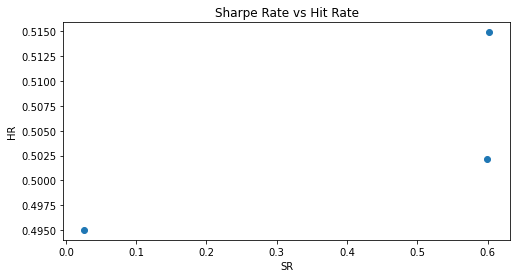

In [975]:
plt.scatter(sharpes, hits)
plt.title('Sharpe Rate vs Hit Rate')

plt.xlabel('SR')
plt.ylabel('HR')

plt.show()

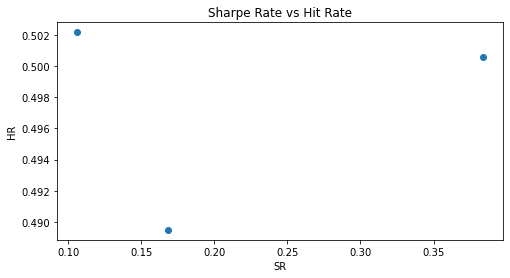

In [974]:
plt.scatter(sharpes1, hits1)
plt.title('Sharpe Rate vs Hit Rate')

plt.xlabel('SR')
plt.ylabel('HR')

plt.show()

### Задание 5

In [1117]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

from sklearn import linear_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#### Загружаем из файла

In [1118]:
df = pd.read_csv('data/xtask.csv')

#### Смотрим основные статистики

In [1119]:
df.describe()

,a,b,c,d,class
count,3839.000000,3839.000000,3839.000000,3839.000000,3071.00000
mean,0.000237,-0.001918,-0.005020,0.017286,0.65972
std,0.492286,0.493000,0.489641,0.504631,0.47388
min,-0.995371,-0.996342,-0.996055,-0.998084,0.00000
25%,-0.394078,-0.395845,-0.395307,-0.386948,0.00000
50%,-0.008509,-0.010900,-0.015388,0.015544,1.00000
75%,0.399061,0.395606,0.382006,0.436341,1.00000
max,0.995987,0.993865,0.988428,0.997183,1.00000


In [1120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       3839 non-null   float64
 1   b       3839 non-null   float64
 2   c       3839 non-null   float64
 3   d       3839 non-null   float64
 4   class   3071 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


#### Проверяем структуру данных в колонке класс (значения, пропуски)

In [1121]:
df['class'].unique()

array([ 1.,  0., nan])

In [1122]:
df['class'].value_counts()

1.0    2026
0.0    1045
Name: class, dtype: int64

<AxesSubplot:>

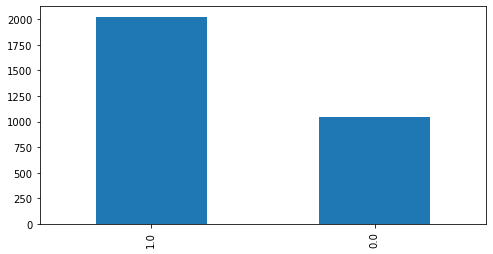

In [1123]:
df['class'].value_counts().plot.bar()

Видим дисбаланс классов.

#### Строим гистограмму признаков (a, b, c, d). Они имеют одинаковое распределение в диапазоне от -1 до +1.

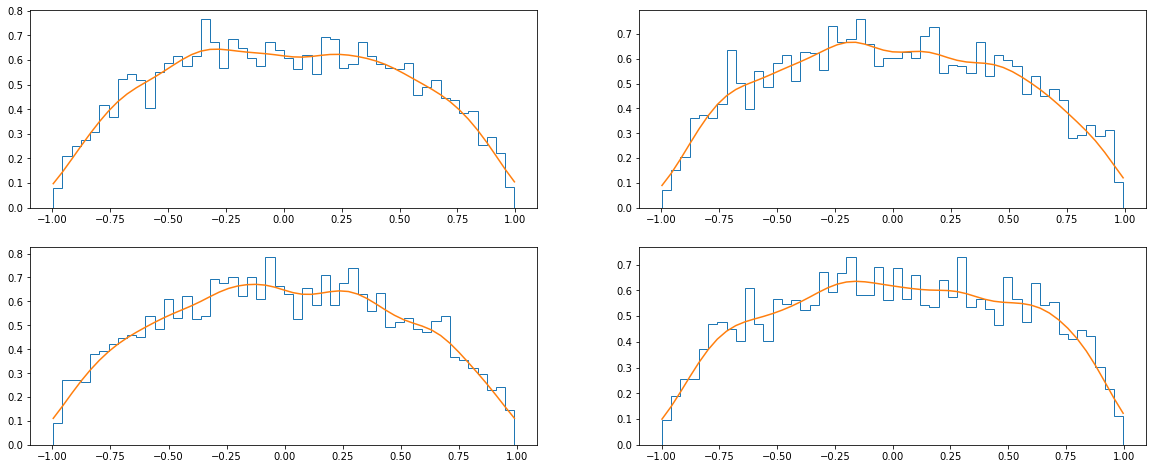

In [1124]:
features = ['a', 'b', 'c', 'd']
plt.subplots(figsize = (20,8))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    data = df[col]
    n, x, _ = plt.hist(data, bins=50, histtype=u'step', density=True)
    gauss = stats.gaussian_kde(data)
    plt.plot(x, gauss(x))
plt.show()

#### Выносим строки с пропусками в отдельный датафрейм - он станет тестовым. Из обучающего датафрейма удаляем строки с пропусками.

In [1127]:
df_test = df[df.isnull().any(1)].reset_index()

In [1128]:
df_train = df.dropna().reset_index(drop = True)

#### Обучающий датафрейм делим на учебный и валидационный

In [1129]:
X = df_train[['a', 'b', 'c', 'd']]
y = df_train[['class']]

In [1130]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=27)

#### Подбираем классифкаторы - SVC (опорные вектора), KNN (ближайшие соседи), GNB (наивный байес)

In [1131]:
SVC_model = SVC()

KNN_model = KNeighborsClassifier(n_neighbors = 5)

GNB_model = GaussianNB()

In [1132]:
SVC_model.fit(X_train, y_train.values.ravel())

KNN_model.fit(X_train, y_train.values.ravel())

GNB_model.fit(X_train, y_train.values.ravel())

GaussianNB()

Делаем предсказания

In [1133]:
SVC_prediction = SVC_model.predict(X_val)
KNN_prediction = KNN_model.predict(X_val)
GNB_prediction = GNB_model.predict(X_val)

Смотрим на метрики

In [1134]:
print(X_val.shape)
print(y_val.shape)

(768, 4)
(768, 1)


In [1135]:
print(accuracy_score(SVC_prediction, y_val))
print(accuracy_score(KNN_prediction, y_val))
print(accuracy_score(GNB_prediction, y_val))

print(confusion_matrix(SVC_prediction, y_val))
print(confusion_matrix(KNN_prediction, y_val))
print(confusion_matrix(GNB_prediction, y_val))

0.6888020833333334
0.60546875
0.6822916666666666
[[  5   0]
 [239 524]]
[[ 66 125]
 [178 399]]
[[  0   0]
 [244 524]]


In [1136]:
print('KNN метрики \n', classification_report(KNN_prediction, y_val))

KNN метрики 
               precision    recall  f1-score   support

         0.0       0.27      0.35      0.30       191
         1.0       0.76      0.69      0.72       577

    accuracy                           0.61       768
   macro avg       0.52      0.52      0.51       768
weighted avg       0.64      0.61      0.62       768



#### Пробуем случайный лес

In [1138]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 0)

In [1139]:
RF_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=50, random_state=0)

In [1140]:
RF_prediction = RF_model.predict(X_val)

In [1141]:
print(accuracy_score(RF_prediction, y_val))
print(confusion_matrix(RF_prediction, y_val))

0.6145833333333334
[[ 58 110]
 [186 414]]


#### Деревья решений

In [1142]:
DT_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)

In [1143]:
DT_model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=4, random_state=0)

In [1144]:
DT_prediction = DT_model.predict(X_val)

In [1145]:
print(accuracy_score(DT_prediction, y_val))
print(confusion_matrix(DT_prediction, y_val))

0.66796875
[[  8  19]
 [236 505]]


Вывод:

- без использования подбора гиперпаратров и оптимизации наидучший результат показали модели: SVC и GNB 
- предполодим что сбаланисирование целевого признака даст лучший результат предсказания.

#### Делаем прогноз на тестовых данных задания с помощью SVC

In [1149]:
X_t = df_test[['a', 'b', 'c', 'd']]
y_t = df_test[['class']]

In [1150]:
SVC_prediction_t = SVC_model.predict(X_t)

In [1156]:
np.savetxt ('Y_test.csv', SVC_prediction_t, delimiter=' , ')